# Setup

In [15]:
# imports
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, json
from sklearn_extra.cluster import KMedoids

In [12]:
# get segmented df from other notebook
%store -r rfm_segments_df
rfm_df = rfm_segments_df.copy()
display(rfm_df.head())

,recency,frequency,monetary,segment
customer_id,,,,
1,183,3,118711.78,2
2,213,2,100306.58,0
3,188,4,119028.73,2
4,441,3,142874.25,0
5,132,4,120783.07,2


In [16]:
# get final cluster model
%store -r rfm_model
cluster_model = rfm_model
display(cluster_model)

KMedoids(init='k-medoids++', method='pam', n_clusters=3, random_state=42)

# Describe Segments
---

## Analysis: Update Segment Labels

**Segment 0 <ins>(Potential Loyalists)**</ins>--> largest segment with 56.52% of customers and makes up largest portion of revenue with 60.28% of total revenue
- ***Monetary:*** <ins>above average</ins> (averaging $109,449.61 total spend)--> between 50th and 75th percentile
- ***Frequency:*** <ins>mid to slightly above average</ins> (averaging 3.3 orders per customer)--> around 50th and 75th percentile
- ***Recency:*** <ins>above average</ins> (averaging 125 days since last purchase)--> between 25th and 50th percentile--lower is better here

**Segment 1 <ins>(Hibernating)**</ins>--> second largest segment with 41.30% of customers and makes up only 24.44% of total revenue
- ***Monetary:*** <ins>significantly below average</ins> (averaging $60,734.61 total spend)--> below 25th percentile
- ***Frequency:*** <ins>below average</ins> (averaging 2.13 orders per customer)--> around 25th percentile
- ***Recency:*** <ins>significantly below average</ins> (averaging 284 days since last purchase)--> greater than 75th percentile

**Segment 2 <ins>(Champions)**</ins>--> very small segment with only 2.17% of customers yet makes up 15.28% of total revenue
- ***Monetary:*** <ins>significantly above average</ins> (averaging $721,462.27 total spend)--> above 75th percentile
- ***Frequency:*** <ins>significantly above average</ins> (averaging 19.5 orders per customer)--> above 75th percentile
- ***Recency:*** <ins>significantly above average</ins> (averaging 34.5 days since last purchase)--> less than 25th percentile

In [13]:
# update segment labels
segment_labels_dict = {
    0: 'Potential Loyalist',
    1: 'Hibernating',
    2: 'Champion'
}
rfm_df['segment'] = rfm_df['segment'].replace(segment_labels_dict)

rfm_df.head()

,recency,frequency,monetary,segment
customer_id,,,,
1,183,3,118711.78,Champion
2,213,2,100306.58,Potential Loyalist
3,188,4,119028.73,Champion
4,441,3,142874.25,Potential Loyalist
5,132,4,120783.07,Champion


## RFM Distributions

### Overall

In [4]:
# overall
print('OVERALL'.center(53, '-'))
rfm_df.describe()

-----------------------OVERALL-----------------------


,recency,frequency,monetary
count,92.000000,92.000000,92.000000
mean,189.054348,3.152174,102632.819130
std,122.804353,2.626721,100766.634779
min,0.000000,1.000000,9129.350000
25%,101.750000,2.000000,66129.007500
50%,181.000000,3.000000,85360.000000
75%,243.250000,3.000000,115616.882500
max,494.000000,23.000000,795328.220000


### By Segment

In [5]:
# summary stats
cnt = 0
for segment in list(rfm_df.segment.unique()):
    print(f'Segment {cnt}: {segment}'.center(53, '-'))
    display(rfm_df[rfm_df.segment == segment].describe())

    cnt+=1

----------------Segment 0: Hibernating---------------


,recency,frequency,monetary
count,54.000000,54.000000,54.000000
mean,126.074074,3.277778,107076.190370
std,78.183348,0.626962,34528.498437
min,0.000000,2.000000,33440.100000
25%,68.250000,3.000000,81871.255000
50%,130.500000,3.000000,104466.170000
75%,180.750000,3.750000,120741.122500
max,441.000000,5.000000,200995.410000


------------Segment 1: Potential Loyalist------------


,recency,frequency,monetary
count,36.000000,36.000000,36.000000
mean,292.111111,2.055556,61588.348611
std,107.336794,0.333333,25237.783436
min,98.000000,1.000000,9129.350000
25%,213.750000,2.000000,43740.777500
50%,249.500000,2.000000,61295.375000
75%,380.000000,2.000000,78486.687500
max,494.000000,3.000000,117713.560000


-----------------Segment 2: Champion-----------------


,recency,frequency,monetary
count,2.000000,2.000000,2.000000
mean,34.500000,19.500000,721462.265000
std,28.991378,4.949747,104462.235359
min,14.000000,16.000000,647596.310000
25%,24.250000,17.750000,684529.287500
50%,34.500000,19.500000,721462.265000
75%,44.750000,21.250000,758395.242500
max,55.000000,23.000000,795328.220000


## Boxplots

### RFM

##### Recency

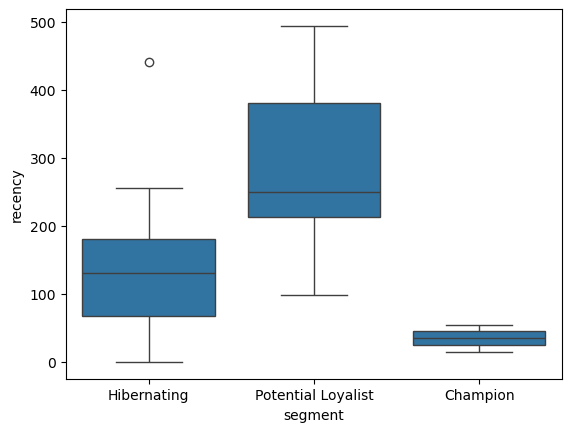

In [6]:
sns.boxplot(x='segment', y='recency', data=rfm_df)
plt.show()

##### Frequency

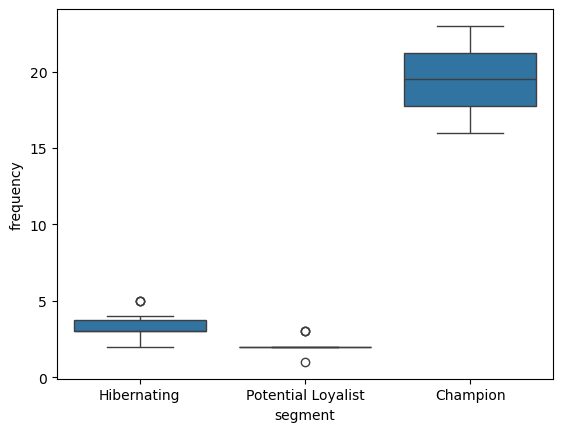

In [7]:
sns.boxplot(x='segment', y='frequency', data=rfm_df)
plt.show()

##### Monetary

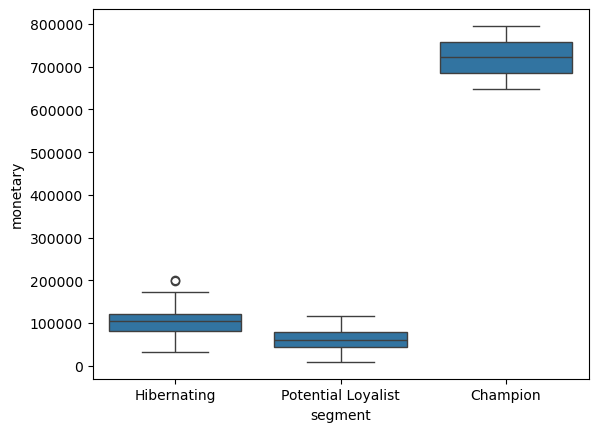

In [8]:
sns.boxplot(x='segment', y='monetary', data=rfm_df)
plt.show()

### Overall

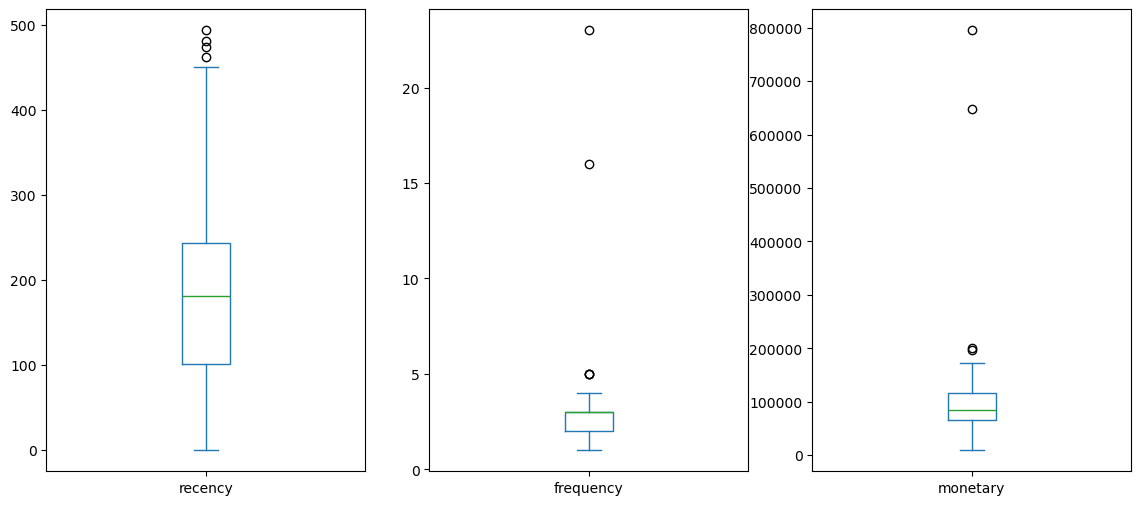

In [9]:
rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

## Pie Charts & Quick Stats

,segment,Recency_mean,Frequency_mean,Monetary_mean,Monetary_total,count
0,Champion,34.500000,19.500000,721462.265000,1442924.53,2
1,Hibernating,126.074074,3.277778,107076.190370,5782114.28,54
2,Potential Loyalist,292.111111,2.055556,61588.348611,2217180.55,36


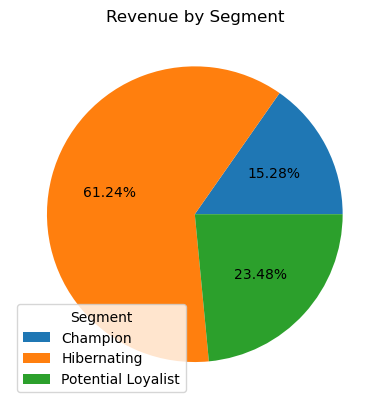

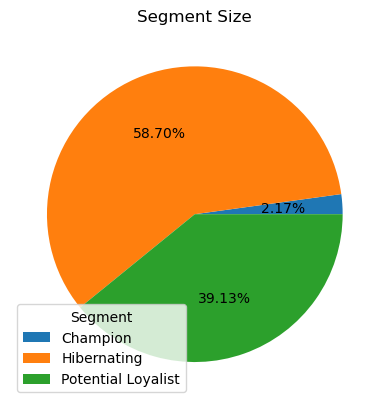

In [11]:
# build summary table of means and revenue/size totals
rfm_cols = ['recency', 'frequency', 'monetary']

segment_summary_df = (
    rfm_df.groupby('segment').agg(
        Recency_mean        = ('recency', 'mean'),
        Frequency_mean      = ('frequency', 'mean'),
        Monetary_mean       = ('monetary', 'mean'),
        Monetary_total      = ('monetary', 'sum'),
        count               = ('segment', 'count')
    ).sort_values('Monetary_mean', ascending=False).reset_index()
)

# ----displays------------------------------
# summary table
display(segment_summary_df)

# pie chart: segments' revenue proportions 
segment_summary_df.plot.pie(
    y='Monetary_total', labels=segment_summary_df['segment'],
    autopct='%1.2f%%', labeldistance=None, ylabel='', title='Revenue by Segment'
    
)
plt.legend(loc='lower left', title='Segment')
plt.show()

# pie chart: segments' proportion of customers
segment_summary_df.plot.pie(
    y='count', labels=segment_summary_df['segment'], 
    autopct='%1.2f%%', labeldistance=None, ylabel='', title='Segment Size'
)
plt.legend(loc='lower left', title='Segment')
plt.show()

# Save Final
---

## Analysis date range

In [14]:
# get analysis time range decided before
%store -r rfm_date_range
display(rfm_date_range)

{'start_date': '2003-01-06', 'end_date': '2005-05-17'}

In [15]:
# save date range into json for later db input
with open('../config/rfm_dates.json', 'w') as fp:
    json.dump(rfm_date_range, fp)

## RFM values with labels

In [13]:
# prepare to store results
final_rfm_df = rfm_df.copy()
final_rfm_df.monetary = final_rfm_df.monetary.round(2)
final_rfm_df = final_rfm_df.rename(columns={
    'recency': 'recency_days',
    'monetary': 'monetary_amt',
    'segment': 'label'
}).reset_index()
display(final_rfm_df.head())

# store data
final_rfm_df.to_csv('../data/derived/rfm_labels.csv', index=False)

,customer_id,recency_days,frequency,monetary_amt,label
0,1,183,3,118711.78,Potential Loyalist
1,2,213,2,100306.58,Hibernating
2,3,188,4,119028.73,Potential Loyalist
3,4,441,3,142874.25,Potential Loyalist
4,5,132,4,120783.07,Potential Loyalist
